In [34]:
# Import necessary functions and modules from the script
from LSTM_Model_Training import (
    get_config,
    preprocess_aachen_dataset,
    build_model,
    plot_training_history,
    plot_predictions_vs_actual,
    plot_residuals,
    explain_with_shap,
    save_model_structure_and_weights,
    load_model_structure_and_weights,
    get_unique_model_name
)

import pandas as pd
import tensorflow as tf

# Enable eager execution
tf.compat.v1.enable_eager_execution()

Attempting to load pre-trained model...
Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250128_130021.structure.json
Weights file: Aachen/Models/model_20250128_130021.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250127_135003.weights.h5']
No pre-trained model found. Training a new model...
Epoch 1/50


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0328 - mae: 0.1230 - val_loss: 0.0045 - val_mae: 0.0528
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0060 - mae: 0.0580 - val_loss: 0.0041 - val_mae: 0.0483
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0058 - mae: 0.0568 - val_loss: 0.0042 - val_mae: 0.0480
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0055 - mae: 0.0558 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0052 - mae: 0.0545 - val_loss: 0.0044 - val_mae: 0.0519
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0049 - mae: 0.0533 - val_loss: 0.0046 - val_mae: 0.0484
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0051 - mae: 0.0534 - val_loss: 0.0044 - val_mae: 0.0478
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0048 - mae: 0.0527 - val_loss: 0.0041 - val_mae: 0.0480
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - los

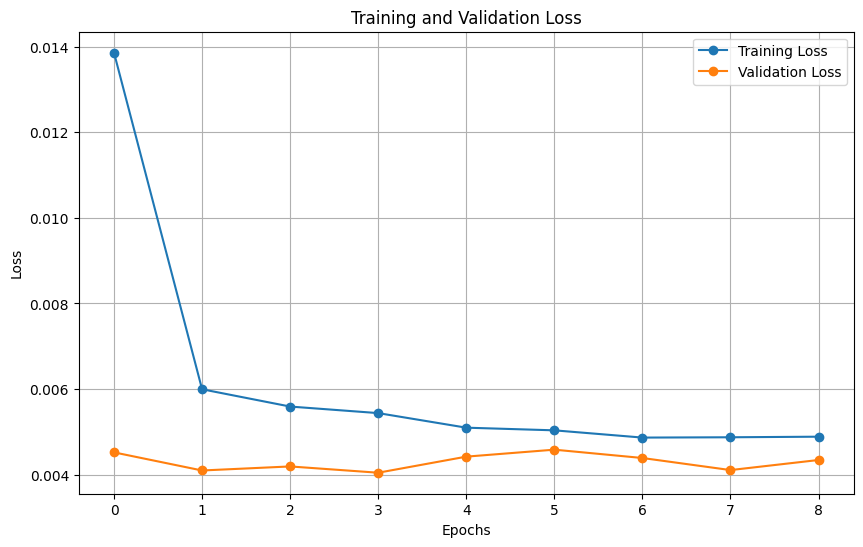

In [35]:

# Step 1: Load configuration
config = get_config()

# Step 2: Preprocess the Aachen dataset
data_path = "/Users/johannesherstad/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat"
aachen_data = preprocess_aachen_dataset(
    data_path,
    test_cell_count=3,
    random_state=42,
    phase=None,
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]

# Step 3: Define model name for loading or saving
model_name = None
#model_name = "Aachen/Models/model_20250127_135003"  # Update as needed

if model_name is None:
    model_name = get_unique_model_name()

# Step 4: Load or train the model
try:
    print("Attempting to load pre-trained model...")
    model = load_model_structure_and_weights(model_name)
    print("Pre-trained model loaded successfully.")
except FileNotFoundError:
    print("No pre-trained model found. Training a new model...")

    # Build the model
    model = build_model(X_train_lstm.shape[1:], config)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=config["patience"], restore_best_weights=True
        )
    ]

    # Train the model
    history = model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=1,
        callbacks=callbacks
    )

    # Save the best model after training
    save_model_structure_and_weights(model, model_name)
    print(f"New model saved as {model_name}")

    # Plot training history
    plot_training_history(history)



In [36]:
# Step 5: Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4431e-04 - mae: 0.0227

Test Loss: 0.0008722370257601142
Test MAE: 0.02526727505028248
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1045.809204
1        1055.0      1037.958374
2        1050.0      1030.179199
3        1045.0      1022.603821
4        1040.0      1015.309998


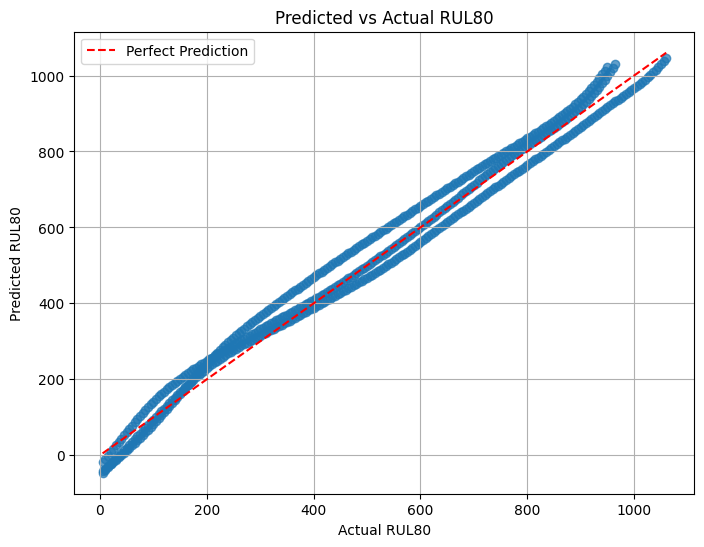

In [37]:
# Step 7: Visualize predictions and residuals
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)


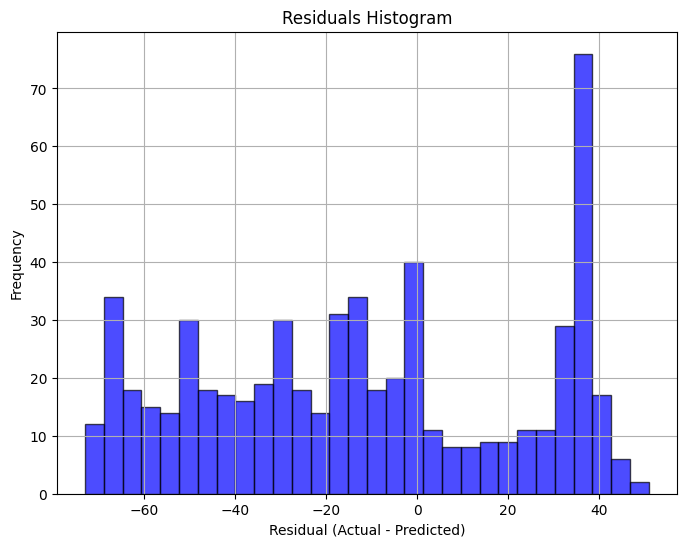

In [38]:
plot_residuals(y_test_rescaled, y_pred_rescaled)


In [39]:
import numpy as np
import shap
import tensorflow as tf

# Function to sample evenly across different cells
def sample_background_data(X_train_lstm, num_samples=100):
    unique_cells = np.unique(cell_ids)  # Assuming you have an array 'cell_ids' indicating the cell for each row
    sampled_indices = []
    
    for cell in unique_cells:
        cell_indices = np.where(cell_ids == cell)[0]  # Get all indices for this cell
        last_index = cell_indices[-1]  # Use the final (largest window) for each cell
        sampled_indices.append(last_index)

    # If we have more samples than needed, randomly sample from them
    if len(sampled_indices) > num_samples:
        sampled_indices = np.random.choice(sampled_indices, num_samples, replace=False)

    return X_train_lstm[sampled_indices]

# Get representative background samples
background_data = sample_background_data(X_train_lstm, num_samples=100)
background_data = background_data.reshape(background_data.shape[0], -1)  # Flatten

# Select diverse test samples (one per cell if possible)
test_sample_indices = [np.where(cell_ids == cell)[0][-1] for cell in np.unique(cell_ids)[:10]]
test_samples = X_test_lstm[test_sample_indices].reshape(len(test_sample_indices), -1)

# Wrap model.predict for reshaping
def wrapped_predict(data):
    reshaped_data = data.reshape(data.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])
    return model.predict(reshaped_data)

# Create SHAP KernelExplainer with improved background sampling
explainer = shap.KernelExplainer(wrapped_predict, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)


NameError: name 'cell_ids' is not defined

SHAP values shape (squeezed): (10, 272)
Test samples shape: (10, 272)


Generating force plot for the first test sample...
Generating summary plot...


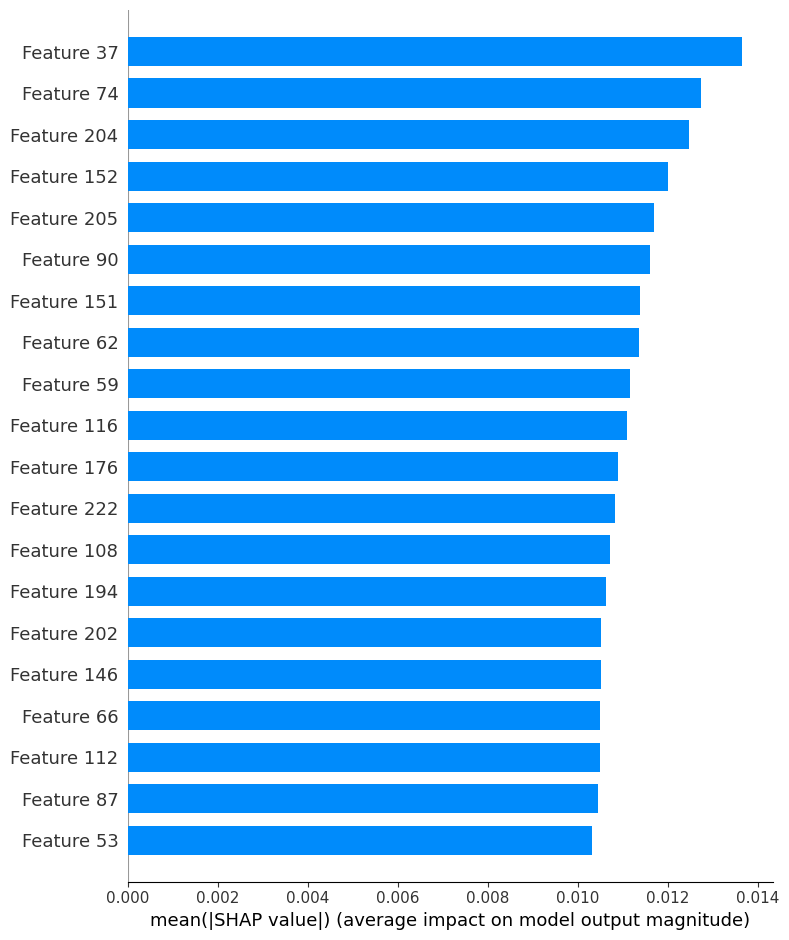

In [ ]:
import numpy as np

# Squeeze SHAP values to remove the last dimension if necessary
shap_values_squeezed = np.array(shap_values).squeeze()

# Debug shapes to ensure compatibility
print("SHAP values shape (squeezed):", shap_values_squeezed.shape)
print("Test samples shape:", test_samples.shape)

# Initialize SHAP JS visualization
shap.initjs()

# Verify the base value
base_value = explainer.expected_value if isinstance(explainer.expected_value, (float, int)) else explainer.expected_value[0]

# Plot feature contributions for the first test sample
print("Generating force plot for the first test sample...")
shap.force_plot(
    base_value,              # Base value (scalar)
    shap_values_squeezed[0], # SHAP values for the first test sample
    test_samples[0]          # Feature values for the first test sample
)

# Summarize feature importance across all test samples
print("Generating summary plot...")
shap.summary_plot(
    shap_values_squeezed,    # SHAP values for all test samples
    test_samples,            # Test samples (flattened)
    plot_type="bar"
)


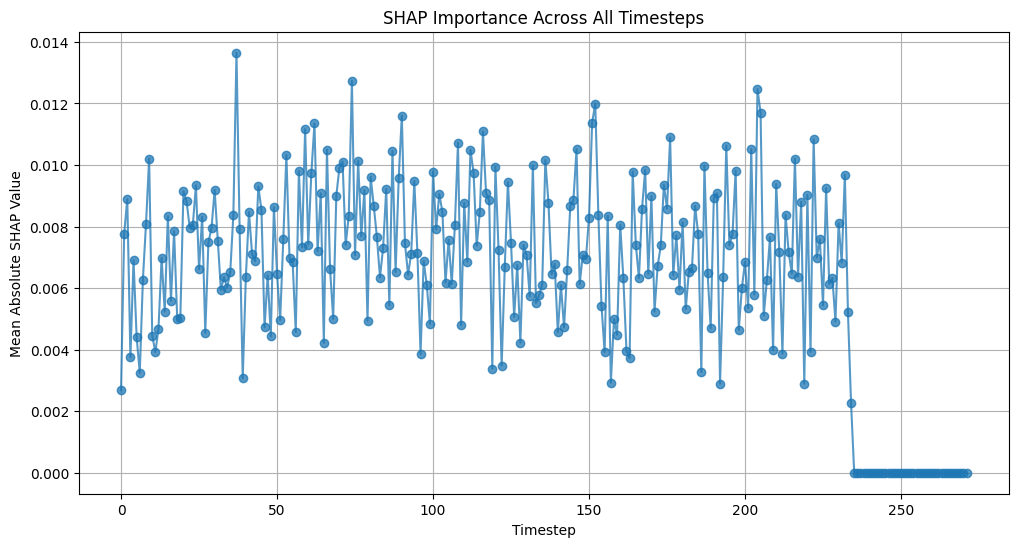

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure shap_values is a NumPy array and squeeze the dimensions if needed
shap_values_squeezed = np.array(shap_values).squeeze()

# Compute the mean absolute SHAP values per timestep
mean_shap_values = np.mean(np.abs(shap_values_squeezed), axis=0)  # Average importance per timestep

# Generate the plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(mean_shap_values)), mean_shap_values, marker='o', linestyle='-', alpha=0.75)

# Labels and formatting
plt.xlabel("Timestep")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("SHAP Importance Across All Timesteps")
plt.grid(True)

# Show the plot
plt.show()


In [27]:
print("Original LSTM input shape:", X_train_lstm.shape)  # Expected (n_samples, timesteps, features_per_timestep)


Original LSTM input shape: (7190, 272, 1)


In [28]:
print("Flattened feature count:", test_samples.shape[1])  # Should be timesteps * features_per_timestep


Flattened feature count: 272


In [40]:
import shap
import tensorflow as tf
import numpy as np

# Squeeze SHAP values to remove the last dimension if necessary
shap_values_squeezed = np.array(shap_values).squeeze()

# Debug shapes to ensure compatibility
print("SHAP values shape (squeezed):", shap_values_squeezed.shape)
print("Test samples shape:", test_samples.shape)

# Initialize SHAP JS visualization
shap.initjs()

# Verify the base value
base_value = explainer.expected_value if isinstance(explainer.expected_value, (float, int)) else explainer.expected_value[0]

# Plot feature contributions for the first test sample (force plot)
print("Generating force plot for the first test sample...")

# Plot feature contributions for the first test sample
print("Generating force plot for the first test sample...")
shap.force_plot(
    base_value,              # Base value (scalar)
    shap_values_squeezed[0], # SHAP values for the first test sample
    test_samples[0]          # Feature values for the first test sample
)

# Display the force plot inline in the notebook
from IPython.core.display import display, HTML
display(HTML(force_plot_html.html()))


SHAP values shape (squeezed): (10, 272)
Test samples shape: (10, 272)


Generating force plot for the first test sample...
Generating force plot for the first test sample...


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_5658/1042856995.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


TypeError: Object of type float32 is not JSON serializable

In [41]:
import numpy as np

print("SHAP values shape:", np.array(shap_values).shape)
print("Test samples shape:", test_samples.shape)


SHAP values shape: (10, 272, 1)
Test samples shape: (10, 272)


In [42]:
import shap
import numpy as np

# Debug shapes
print("SHAP values shape (should match test_samples):", shap_values.shape)
print("Test samples shape:", test_samples.shape)

# Initialize SHAP JS visualization
shap.initjs()

# Verify expected_value dimensions
base_value = explainer.expected_value if isinstance(explainer.expected_value, (float, int)) else explainer.expected_value[0]

# Plot feature contributions for the first test sample
shap.force_plot(
    base_value,               # Base value (scalar)
    shap_values_squeezed,     # SHAP values for the first test sample
    test_samples[0]           # Feature values for the first test sample
)


SHAP values shape (should match test_samples): (10, 272, 1)
Test samples shape: (10, 272)


TypeError: Object of type float32 is not JSON serializable

In [53]:
import numpy as np
import shap
import tensorflow as tf

# Function to sample a more diverse background dataset
def sample_background_data(X_train_lstm, y_train, num_samples=100):
    """
    Selects background data ensuring diversity across different cells
    and degradation stages (early, mid, late).
    """
    num_total_samples = X_train_lstm.shape[0]
    sampled_indices = []

    # Ensure we cover different RUL ranges
    early_indices = np.where(y_train > 0.8)[0]  # Early life
    mid_indices = np.where((y_train > 0.4) & (y_train <= 0.8))[0]  # Mid-life
    late_indices = np.where(y_train <= 0.4)[0]  # Near failure

    # Sample evenly from different life phases
    for indices in [early_indices, mid_indices, late_indices]:
        if len(indices) > 0:
            sampled_indices.extend(np.random.choice(indices, size=min(len(indices), num_samples // 3), replace=False))

    # If we don’t have enough, sample additional points randomly
    while len(sampled_indices) < num_samples:
        sampled_indices.append(np.random.randint(0, num_total_samples))

    sampled_indices = np.array(sampled_indices[:num_samples])

    return X_train_lstm[sampled_indices]

# Select a more balanced background dataset
background_data = sample_background_data(X_train_lstm, y_train, num_samples=100)
background_data = background_data.reshape(background_data.shape[0], -1)  # Flatten

# Select diverse test samples (last window per unique cell)
test_sample_indices = np.linspace(0, X_test_lstm.shape[0] - 1, 10, dtype=int)  # Evenly spaced across dataset
test_samples = X_test_lstm[test_sample_indices].reshape(len(test_sample_indices), -1)

# Wrap model.predict for reshaping
def wrapped_predict(data):
    reshaped_data = data.reshape(data.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])
    return model.predict(reshaped_data)

# Create SHAP KernelExplainer with improved background sampling
explainer2 = shap.Explainer(wrapped_predict, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7938/7938 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step


In [54]:
shap_values = explainer2.shap_values(test_samples)


615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


PermutationExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


PermutationExplainer explainer:  30%|███       | 3/10 [00:44<01:26, 12.36s/it]

1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


PermutationExplainer explainer:  40%|████      | 4/10 [01:18<02:06, 21.06s/it]

1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


PermutationExplainer explainer:  50%|█████     | 5/10 [02:01<02:26, 29.29s/it]

726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


PermutationExplainer explainer:  60%|██████    | 6/10 [02:24<01:49, 27.36s/it]

982/982 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


PermutationExplainer explainer:  70%|███████   | 7/10 [02:56<01:26, 28.85s/it]

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


PermutationExplainer explainer:  80%|████████  | 8/10 [03:37<01:05, 32.83s/it]

744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


PermutationExplainer explainer:  90%|█████████ | 9/10 [04:02<00:30, 30.17s/it]

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


PermutationExplainer explainer: 100%|██████████| 10/10 [04:34<00:00, 30.85s/it]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


PermutationExplainer explainer: 11it [05:17, 31.72s/it]                        


In [55]:
import numpy as np
import shap
import tensorflow as tf

# Function to sample a diverse background dataset from all cells
def sample_background_data(X_train_lstm, y_train, cell_ids, num_samples=100):
    """
    Ensures a diverse selection of background data by sampling across different cells
    and different RUL stages (early, mid, late).
    
    Parameters:
    - X_train_lstm: Training data in LSTM format (samples, timesteps, features)
    - y_train: Normalized RUL values for training samples
    - cell_ids: Array mapping each sample to a specific battery cell
    - num_samples: Total number of samples to return
    
    Returns:
    - A more representative set of background samples.
    """
    unique_cells = np.unique(cell_ids)  # Get all unique battery cells
    sampled_indices = []

    # Step 1: Ensure at least one sample from each unique cell
    for cell in unique_cells:
        cell_indices = np.where(cell_ids == cell)[0]  # Get all indices for this cell
        
        if len(cell_indices) > 0:
            final_index = cell_indices[-1]  # Pick the last available window for full history
            sampled_indices.append(final_index)

    # Step 2: Stratified sampling across early, mid, late phases within each cell
    early_indices = np.where(y_train > 0.8)[0]   # Early-life samples
    mid_indices = np.where((y_train > 0.4) & (y_train <= 0.8))[0]  # Mid-life samples
    late_indices = np.where(y_train <= 0.4)[0]   # Near-failure samples

    for indices in [early_indices, mid_indices, late_indices]:
        if len(indices) > 0:
            sampled_indices.extend(np.random.choice(indices, size=min(len(indices), num_samples // 3), replace=False))

    # Step 3: Ensure the sample size is exactly num_samples
    sampled_indices = np.array(list(set(sampled_indices)))  # Remove duplicates
    if len(sampled_indices) > num_samples:
        sampled_indices = np.random.choice(sampled_indices, num_samples, replace=False)
    elif len(sampled_indices) < num_samples:
        additional_samples = np.random.choice(range(len(y_train)), num_samples - len(sampled_indices), replace=False)
        sampled_indices = np.concatenate([sampled_indices, additional_samples])

    return X_train_lstm[sampled_indices]

# Load your dataset (Assuming `cell_ids` is available and matches the training set)
# `cell_ids` should be an array where each entry corresponds to a battery cell number

# Select a more balanced background dataset
background_data = sample_background_data(X_train_lstm, y_train, cell_ids, num_samples=100)
background_data = background_data.reshape(background_data.shape[0], -1)  # Flatten

# Select diverse test samples (ensuring diversity across cells)
test_sample_indices = [np.where(cell_ids == cell)[0][-1] for cell in np.unique(cell_ids)[:10]]  # Last window per cell
test_samples = X_test_lstm[test_sample_indices].reshape(len(test_sample_indices), -1)

# Wrap model.predict for reshaping
def wrapped_predict(data):
    reshaped_data = data.reshape(data.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])
    return model.predict(reshaped_data)

# Create SHAP KernelExplainer with improved background sampling
explainer = shap.KernelExplainer(wrapped_predict, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)


NameError: name 'cell_ids' is not defined

SHAP values shape (squeezed): (10, 272)
Test samples shape: (10, 272)


Generating force plot for the first test sample...
Generating summary plot...


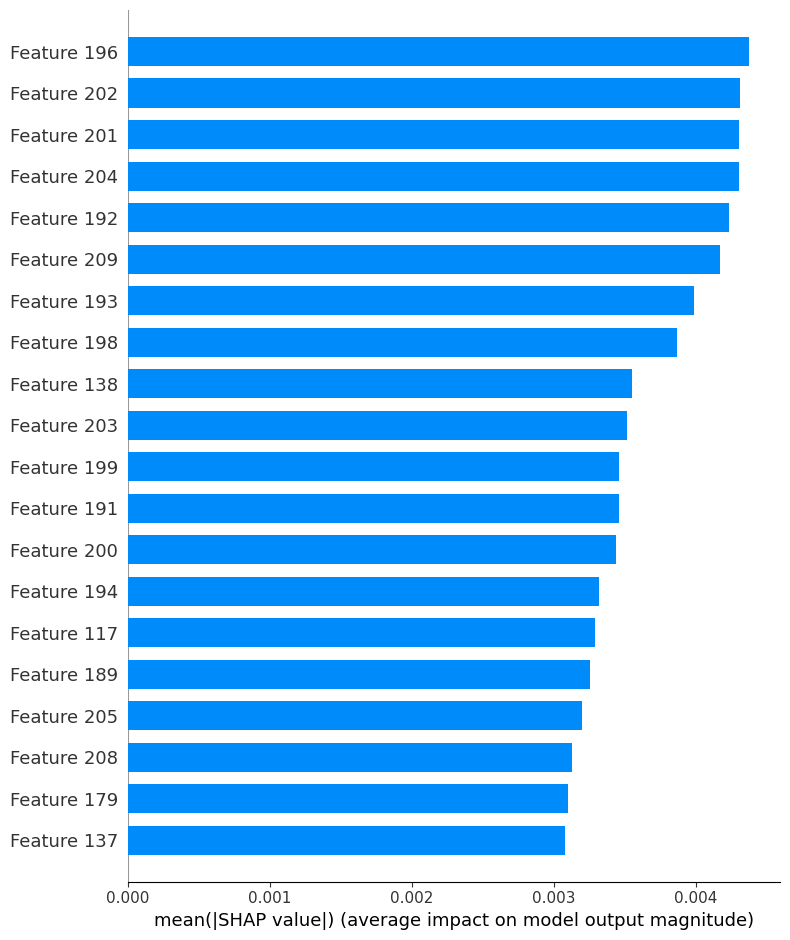

In [56]:
import numpy as np

# Squeeze SHAP values to remove the last dimension if necessary
shap_values_squeezed = np.array(shap_values).squeeze()

# Debug shapes to ensure compatibility
print("SHAP values shape (squeezed):", shap_values_squeezed.shape)
print("Test samples shape:", test_samples.shape)

# Initialize SHAP JS visualization
shap.initjs()

# Verify the base value
base_value = explainer.expected_value if isinstance(explainer.expected_value, (float, int)) else explainer.expected_value[0]

# Plot feature contributions for the first test sample
print("Generating force plot for the first test sample...")
shap.force_plot(
    base_value,              # Base value (scalar)
    shap_values_squeezed[0], # SHAP values for the first test sample
    test_samples[0]          # Feature values for the first test sample
)

# Summarize feature importance across all test samples
print("Generating summary plot...")
shap.summary_plot(
    shap_values_squeezed,    # SHAP values for all test samples
    test_samples,            # Test samples (flattened)
    plot_type="bar"
)


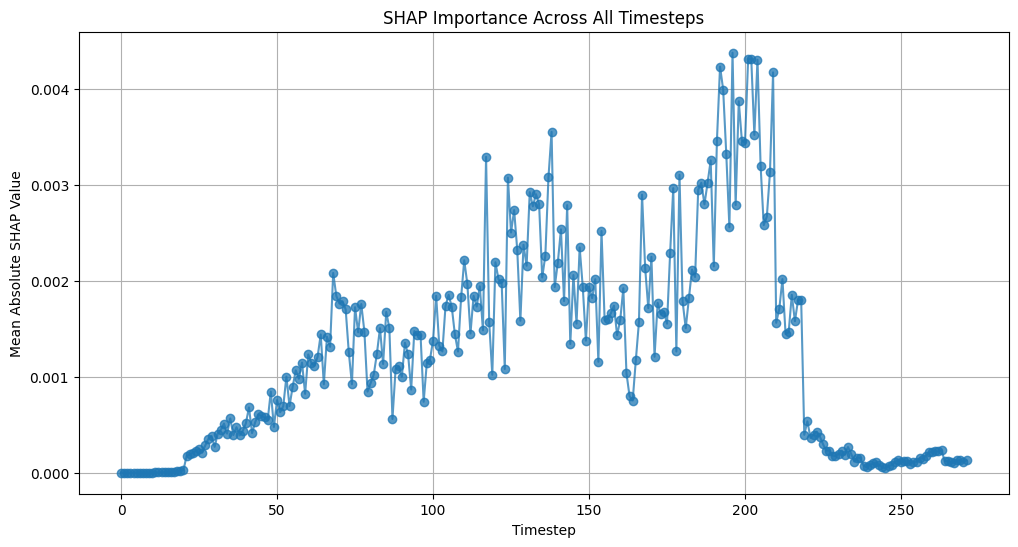

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure shap_values is a NumPy array and squeeze the dimensions if needed
shap_values_squeezed = np.array(shap_values).squeeze()

# Compute the mean absolute SHAP values per timestep
mean_shap_values = np.mean(abs(shap_values_squeezed), axis=0)  # Average importance per timestep

# Generate the plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(mean_shap_values)), mean_shap_values, marker='o', linestyle='-', alpha=0.75)

# Labels and formatting
plt.xlabel("Timestep")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("SHAP Importance Across All Timesteps")
plt.grid(True)

# Show the plot
plt.show()

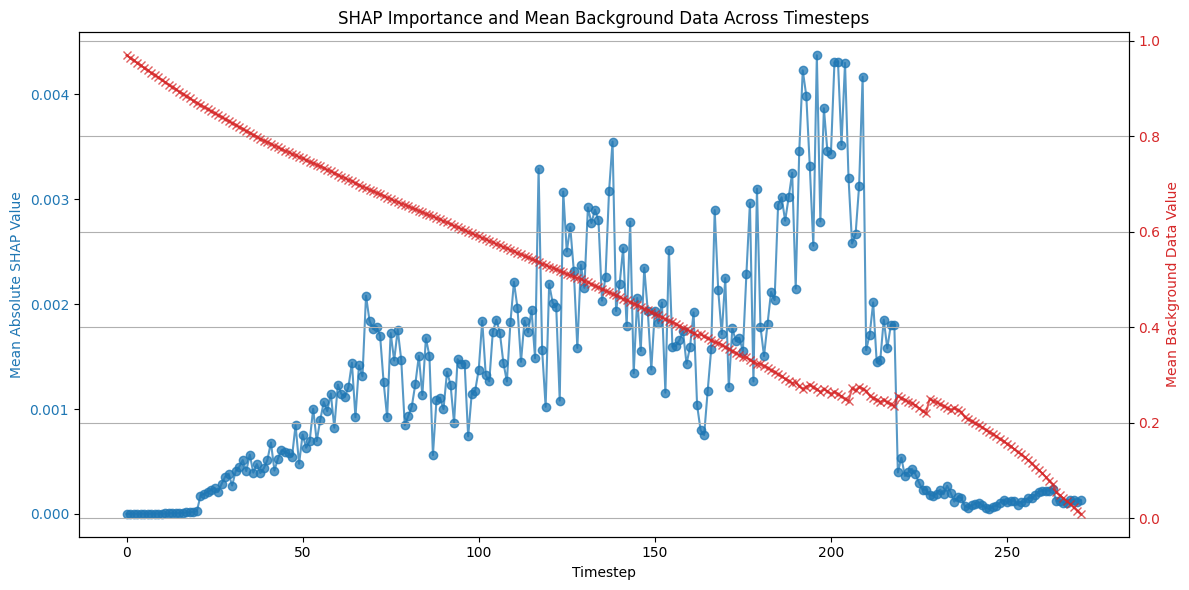

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean absolute SHAP values per timestep
mean_shap_values = np.mean(np.abs(shap_values_squeezed), axis=0)  # Average importance per timestep

# Compute the mean values of the background data per timestep
mean_background_values = np.mean(background_data, axis=0)  # Mean across all samples

def masked_mean(data):
    """Compute mean while ignoring zero values."""
    masked_data = np.where(data == 0, np.nan, data)  # Replace zeros with NaN
    return np.nanmean(masked_data, axis=0)  # Compute mean ignoring NaNs

mean_background_values = masked_mean(background_data)

# Create a dual plot for SHAP values and background data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot SHAP values
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Mean Absolute SHAP Value", color="tab:blue")
ax1.plot(range(len(mean_shap_values)), mean_shap_values, marker='o', linestyle='-', alpha=0.75, color="tab:blue", label="Mean SHAP Value")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for background data mean values
ax2 = ax1.twinx()
ax2.set_ylabel("Mean Background Data Value", color="tab:red")
ax2.plot(range(len(mean_background_values)), mean_background_values, marker='x', linestyle='-', alpha=0.75, color="tab:red", label="Mean Background Value")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add title and grid
plt.title("SHAP Importance and Mean Background Data Across Timesteps")
fig.tight_layout()
plt.grid()

# Show the plot
plt.show()


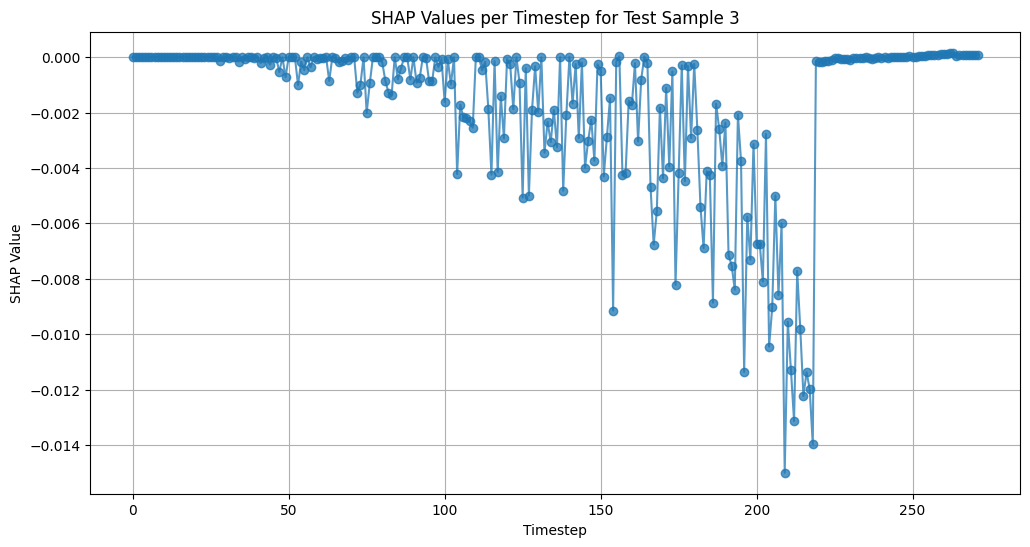

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure shap_values is a NumPy array and squeeze dimensions if needed
shap_values_squeezed = np.array(shap_values).squeeze()

# Select a single prediction (e.g., first test sample)
sample_index = 3  # Change this to visualize different test samples
shap_values_single = shap_values_squeezed[sample_index]  # SHAP values for one prediction

# Generate the plot for a single prediction
plt.figure(figsize=(12, 6))
plt.plot(range(len(shap_values_single)), shap_values_single, marker='o', linestyle='-', alpha=0.75, color='tab:blue')

# Labels and formatting
plt.xlabel("Timestep")
plt.ylabel("SHAP Value")
plt.title(f"SHAP Values per Timestep for Test Sample {sample_index}")
plt.grid(True)

# Show the plot
plt.show()
